In [1]:

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from itertools import combinations
import pickle

# ---------------------------
# 1. Load and preprocess data
# ---------------------------
df = pd.read_csv('../data/Groceries_cleaned_dataset2.csv')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

# Encode users and items
user_ids = df['Member_number'].unique()
item_names = df['itemDescription'].unique()

user2idx = {u: i for i, u in enumerate(user_ids)}
item2idx = {name: j for j, name in enumerate(item_names)}
idx2item = {v: k for k, v in item2idx.items()}

df['user'] = df['Member_number'].map(user2idx)
df['item'] = df['itemDescription'].map(item2idx)

num_users = len(user2idx)
num_items = len(item2idx)

# ---------------------------
# 2. Create training pairs
# ---------------------------
baskets = df.groupby(['user', 'Date'])['item'].apply(list).reset_index()

positive_pairs = []
for row in baskets.itertuples():
    items = sorted(set(row.item))
    if len(items) > 1:
        positive_pairs.extend([(row.user, i, j) for i, j in combinations(items, 2)])

pos_samples = [(u, i, j, 1) for u, i, j in positive_pairs]

positive_set = set((u, i, j) for u, i, j, _ in pos_samples)
neg_samples = []
while len(neg_samples) < len(pos_samples):
    u = np.random.randint(num_users)
    i = np.random.randint(num_items)
    j = np.random.randint(num_items)
    if i != j and (u, i, j) not in positive_set and (u, j, i) not in positive_set:
        neg_samples.append((u, i, j, 0))

all_samples = pos_samples + neg_samples
np.random.shuffle(all_samples)

df_samples = pd.DataFrame(all_samples, columns=['user', 'item1', 'item2', 'label'])

# ---------------------------
# 3. Train/test split
# ---------------------------
train_df, test_df = train_test_split(df_samples, test_size=0.2, random_state=42)

def df_to_dataset(df):
    return tf.data.Dataset.from_tensor_slices((
        {
            "user": df['user'].values,
            "item1": df['item1'].values,
            "item2": df['item2'].values
        },
        df['label'].values
    )).shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df)

# ---------------------------
# 4. Define Hybrid Model
# ---------------------------
from tensorflow.keras.utils import register_keras_serializable

@register_keras_serializable()
class HybridRecModel(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_dim=64, **kwargs):
        super().__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim

        self.user_embedding = tf.keras.layers.Embedding(num_users, embedding_dim)
        self.item_embedding = tf.keras.layers.Embedding(num_items, embedding_dim)

    def call(self, inputs):
        user_emb = self.user_embedding(inputs['user'])
        item1_emb = self.item_embedding(inputs['item1'])
        item2_emb = self.item_embedding(inputs['item2'])
        emb1 = item1_emb + user_emb
        emb2 = item2_emb + user_emb
        dot = tf.reduce_sum(emb1 * emb2, axis=1)
        return tf.nn.sigmoid(dot)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_users": self.num_users,
            "num_items": self.num_items,
            "embedding_dim": self.embedding_dim,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ---------------------------
# 5. Train model
# ---------------------------
model = HybridRecModel(num_users=num_users, num_items=num_items)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=[tf.keras.metrics.BinaryAccuracy()]
)

history = model.fit(train_ds, validation_data=test_ds, epochs=10)

# ---------------------------
# 6. Save model & mappings
# ---------------------------
model.save("hybrid_model.keras")   # Portable .keras format

with open("mappings.pkl", "wb") as f:
    pickle.dump((user2idx, item2idx, idx2item), f)

# ---------------------------
# 7. Vectorized Recommendation
# ---------------------------
def recommend_for_user(user_raw_id, user_basket_names, top_k=5):
    if user_raw_id not in user2idx:
        return []

    user_idx = user2idx[user_raw_id]
    basket_idxs = [item2idx[i] for i in user_basket_names if i in item2idx]

    if not basket_idxs:
        return []

    # Prepare tensors
    user_tensor = tf.constant([user_idx] * len(basket_idxs), dtype=tf.int32)
    basket_tensor = tf.constant(basket_idxs, dtype=tf.int32)

    scores = []
    for item_idx in range(num_items):
        if item_idx in basket_idxs:
            scores.append(-1)  # exclude already seen
            continue

        item_tensor = tf.constant([item_idx] * len(basket_idxs), dtype=tf.int32)
        inputs = {"user": user_tensor, "item1": item_tensor, "item2": basket_tensor}
        preds = model(inputs).numpy()
        scores.append(preds.mean())

    top_indices = np.argsort(scores)[-top_k:][::-1]
    return [idx2item[i] for i in top_indices]

# ---------------------------
# 8. Example usage
# ---------------------------
user_id = 1808
basket = ["whole milk", "rolls/buns"]
print("Recommendations:", recommend_for_user(user_id, basket, top_k=5))




Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.5191 - loss: 0.6632 - val_binary_accuracy: 0.6614 - val_loss: 0.5400
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.6814 - loss: 0.5289 - val_binary_accuracy: 0.6770 - val_loss: 0.5385
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7046 - loss: 0.5133 - val_binary_accuracy: 0.6813 - val_loss: 0.5422
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7168 - loss: 0.5049 - val_binary_accuracy: 0.6781 - val_loss: 0.5463
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7329 - loss: 0.4927 - val_binary_accuracy: 0.6779 - val_loss: 0.5500
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7496 - loss: 0.4792 - val_binary_accuracy: 0.6760 - val_loss: 0.5551
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_accuracy: 0.7655 - loss: 0.4631 - val_binary_accuracy: 0.6715 - val_loss: 0.5628
Epoch 

In [2]:

from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Build user baskets from the dataset (user → list of items)
user_baskets = defaultdict(list)
for _, row in df.iterrows():
    user_baskets[row['user']].append(row['item'])

# Evaluation function
def evaluate_model(model, k_list=[1, 3, 5, 10], num_users=50):
    precision_scores = {k: [] for k in k_list}
    recall_scores = {k: [] for k in k_list}
    ndcg_scores = {k: [] for k in k_list}

    evaluated = 0

    for user_idx, items in user_baskets.items():
        if len(items) < 2:
            continue

        # Hold out one item, use the rest as input
        held_out_item = items[0]
        input_items = items[1:]

        # Convert back to raw IDs
        raw_user_id = [k for k, v in user2idx.items() if v == user_idx][0]
        input_item_names = [idx2item[i] for i in input_items]
        held_out_item_name = idx2item[held_out_item]

        # Get recommendations
        recommended = recommend_for_user(raw_user_id, input_item_names, top_k=max(k_list))

        for k in k_list:
            top_k_items = recommended[:k]
            hit = held_out_item_name in top_k_items

            precision = 1.0 / k if hit else 0.0
            recall = 1.0 if hit else 0.0
            ndcg = 1.0 / np.log2(top_k_items.index(held_out_item_name) + 2) if hit else 0.0

            precision_scores[k].append(precision)
            recall_scores[k].append(recall)
            ndcg_scores[k].append(ndcg)

        evaluated += 1
        if evaluated >= num_users:
            break

    print("\n📊 Evaluation Results (averaged over", evaluated, "users):")
    for k in k_list:
        print(f"Precision@{k}: {np.mean(precision_scores[k]):.4f}")
        print(f"Recall@{k}: {np.mean(recall_scores[k]):.4f}")
        print(f"NDCG@{k}: {np.mean(ndcg_scores[k]):.4f}")
        print('-' * 30)

    return precision_scores, recall_scores, ndcg_scores





📊 Evaluation Results (averaged over 50 users):
Precision@1: 0.0400
Recall@1: 0.0400
NDCG@1: 0.0400
------------------------------
Precision@3: 0.0533
Recall@3: 0.1600
NDCG@3: 0.1131
------------------------------
Precision@5: 0.0520
Recall@5: 0.2600
NDCG@5: 0.1553
------------------------------
Precision@10: 0.0360
Recall@10: 0.3600
NDCG@10: 0.1888
------------------------------


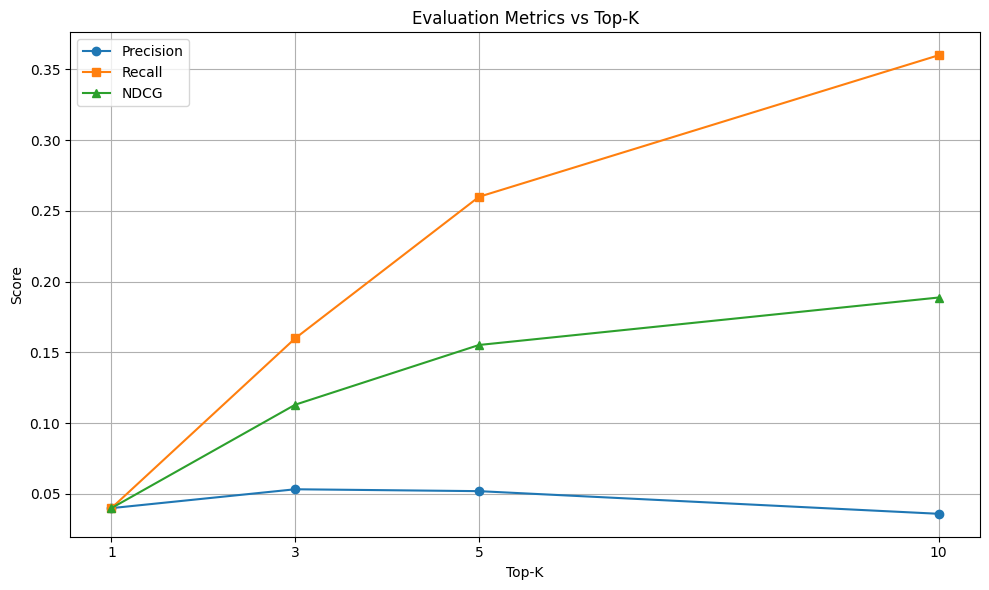

In [3]:
# Run evaluation
precisions, recalls, ndcgs = evaluate_model(model)

# Plot results
k_values = sorted(precisions.keys())

plt.figure(figsize=(10, 6))
plt.plot(k_values, [np.mean(precisions[k]) for k in k_values], label="Precision", marker='o')
plt.plot(k_values, [np.mean(recalls[k]) for k in k_values], label="Recall", marker='s')
plt.plot(k_values, [np.mean(ndcgs[k]) for k in k_values], label="NDCG", marker='^')

plt.title("Evaluation Metrics vs Top-K")
plt.xlabel("Top-K")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()






In [4]:

import tensorflow as tf
print(tf.__version__)

2.20.0


In [4]:

pip uninstall tensorflow



SyntaxError: invalid syntax (2807156199.py, line 1)

In [5]:

import tensorflow as tf
print(tf.__version__)


2.19.0
